In [4]:
import numpy as np

# Define a sample annihilation operator (for example, for a 3-level system)
a = np.array([[0, 1, 0],
              [0, 0, np.sqrt(2)],
              [0, 0, 0]])

# Define a quantum state vector |phi>
phi = np.array([0, 0, 1])

# Apply the annihilation operator to the state
a_phi = a @ phi

# Compute the expectation value
expected_value = np.vdot(a_phi, a_phi)
print(f"Expected photon number: {expected_value}")


Expected photon number: 2.0000000000000004


In [1]:
import scqubits
import numpy as np
from scipy.optimize import minimize
import sys
sys.path.append('../utils/')
from utils_models import *

In [2]:
EJ = 3
EC = EJ/4
EL = EJ/20.5  

qubit_level = 40


def get_shift_accurate(ele,omega_i, omega_j, omega_r):
    return abs(ele)**2 / (omega_j-omega_i-omega_r) - abs(ele)**2 / (omega_i-omega_j-omega_r)


qbt = scqubits.Fluxonium(EJ=EJ,EC=EC,EL=EL,flux=0,cutoff=110,truncated_dim=qubit_level)
evals = qbt.eigenvals(qubit_level)
elements = qbt.matrixelement_table('n_operator',evals_count = qubit_level)

def shift_diff(x):
    Er = x[0]

    shifts_from_one = [get_shift_accurate(elements[1,ql2],evals[ql2],evals[1],Er) for ql2 in range(qubit_level)] 
    shift_from_one = sum(shifts_from_one)
    shifts_from_two = [get_shift_accurate(elements[2,ql2],evals[ql2],evals[2],Er) for ql2 in range(qubit_level)] 
    shift_from_two = sum(shifts_from_two)
    return abs(shift_from_one-shift_from_two)

initial_guess = [8.32993958]

# Call the optimizer
result = minimize(shift_diff, initial_guess, method='Nelder-Mead')

print("Result:", result)
print("Optimal solution:", result.x)
print("Objective value:", result.fun)


Result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.929763204701565e-07
             x: [ 8.461e+00]
           nit: 14
          nfev: 28
 final_simplex: (array([[ 8.461e+00],
                       [ 8.461e+00]]), array([ 4.930e-07,  1.087e-06]))
Optimal solution: [8.46111172]
Objective value: 4.929763204701565e-07


In [3]:
evals[2]-evals[1]

0.03021074796651302

In [4]:
qbt = scqubits.Fluxonium(EJ=EJ,EC=EC,EL=EL,flux=0,cutoff=110,truncated_dim=qubit_level)
evals = qbt.eigenvals(qubit_level)
evals[7]-evals[0]

8.513329394910201

In [6]:
evals[7]-evals[0] - result.x[0], (evals[7]-evals[0] - result.x[0])*2*np.pi

(0.052217670645067216, 0.3280933009722291)

In [14]:
((dressed_ener(0,1)-dressed_ener(0,0))  - result.x[0])*2*np.pi

-0.0032549173393341684

In [11]:
(dressed_ener(1,1)-dressed_ener(1,0) - result.x[0])*2*np.pi

0.0020888785483122595

In [12]:
(dressed_ener(2,1)-dressed_ener(2,0) - result.x[0])*2*np.pi

0.0020855151843195596

In [15]:
((dressed_ener(0,1)-dressed_ener(0,0))  - (dressed_ener(2,1)-dressed_ener(2,0)) )*2*np.pi

-0.005340432523653728

In [8]:

Er = result.x[0]

g = 0.15



max_ol = 80
max_ql = 30
system = FluxoniumOscillatorSystem(
    EJ = EJ,
    EC = EC,
    EL = EL,
    Er = Er,
    g_strength = g,
    qubit_level = max_ql,
    osc_level = max_ol,
    # kappa = 0.004,
    products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
    computaional_states = '1,2'
    )


energies=  system.hilbertspace.eigenvals(max_ql * max_ol)
def dressed_ener(ql,ol):
    return energies[system.product_to_dressed[(ql,ol)]]
def print_stats():
    print(f"\nqubit 12 transition and differential stark at different oscillator level")
    print(f"qbt freq at osc {0}:\t{(dressed_ener(2,0)-dressed_ener(1,0))}")
    ground_freq = dressed_ener(2,0)-dressed_ener(1,0)
    for i in range(1,max_ol-1):
        freq = dressed_ener(2,i)-dressed_ener(1,i)
        print(f"qbt freq at osc {i}:\t{freq:.5f}, \tdiff to at osc ground {freq - ground_freq:.5f}, {abs(freq - ground_freq)/ground_freq*100:.4f}% diff")

    print(f"\noscillator freq at qubit level:\t0 \t 1 \t 2 \t 3:")
    print(f"oscillator transition 0-1: \t{dressed_ener(0,1)-dressed_ener(0,0):.5f}\t{dressed_ener(1,1)-dressed_ener(1,0):.5f}\t{dressed_ener(2,1)-dressed_ener(2,0):.5f}\t{dressed_ener(3,1)-dressed_ener(3,0):.5f}")
    for i in range(1,max_ol-1):
        print(f"oscillator transition {i}-{i+1}: \t{dressed_ener(0,i+1)-dressed_ener(0,i):.5f}\t{dressed_ener(1,i+1)-dressed_ener(1,i):.5f}\t{dressed_ener(2,i+1)-dressed_ener(2,i):.5f}\t{dressed_ener(3,i+1)-dressed_ener(3,i):.5f}  oscillator frequency coupled to qubit 0th state compared to 00-01 (non-linearity): {(dressed_ener(0,i+1)-dressed_ener(0,i))  -(dressed_ener(0,1)-dressed_ener(0,0))}")

    print(f"")
    print(f"10-11: {(dressed_ener(1,1)-dressed_ener(1,0)):.4f}, diff to 00-01: {abs((dressed_ener(0,1)-dressed_ener(0,0))    -(dressed_ener(1,1)-dressed_ener(1,0)))}")
    print(f"20-21: {(dressed_ener(2,1)-dressed_ener(2,0)):.4f}, diff to 00-01: {abs((dressed_ener(0,1)-dressed_ener(0,0))    -(dressed_ener(2,1)-dressed_ener(2,0)))}")
print_stats()
# plot_specturum(system.qbt, system.osc, system.hilbertspace,num_levels = 50)


qubit 12 transition and differential stark at different oscillator level
qbt freq at osc 0:	0.030195212393025805
qbt freq at osc 1:	0.03019, 	diff to at osc ground -0.00000, 0.0018% diff
qbt freq at osc 2:	0.03019, 	diff to at osc ground -0.00000, 0.0041% diff
qbt freq at osc 3:	0.03019, 	diff to at osc ground -0.00000, 0.0069% diff
qbt freq at osc 4:	0.03019, 	diff to at osc ground -0.00000, 0.0102% diff
qbt freq at osc 5:	0.03019, 	diff to at osc ground -0.00000, 0.0139% diff
qbt freq at osc 6:	0.03019, 	diff to at osc ground -0.00001, 0.0181% diff
qbt freq at osc 7:	0.03019, 	diff to at osc ground -0.00001, 0.0227% diff
qbt freq at osc 8:	0.03019, 	diff to at osc ground -0.00001, 0.0277% diff
qbt freq at osc 9:	0.03019, 	diff to at osc ground -0.00001, 0.0331% diff
qbt freq at osc 10:	0.03018, 	diff to at osc ground -0.00001, 0.0389% diff
qbt freq at osc 11:	0.03018, 	diff to at osc ground -0.00001, 0.0450% diff
qbt freq at osc 12:	0.03018, 	diff to at osc ground -0.00002, 0.0515% 

In [9]:
dressed_ener(1,1)-dressed_ener(1,0)

8.461444179611616

In [10]:
dressed_ener(0,1)-dressed_ener(0,0)

8.460593688081223

# g0.2

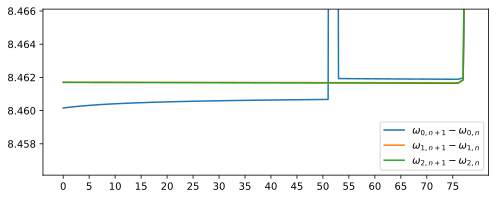

In [5]:
plt.figure(figsize = (8,3))
n_osc_lvls = max_ol-1
dressed_osc_frequencies = [[] for _ in range(3)]
for j in [0,1,2]:
    for i in range(0,max_ol-1):
        dressed_osc_frequencies[j].append(dressed_ener(j,i+1)-dressed_ener(j,i))
        
for j in [0,1,2]:
    plt.plot(list(range(max_ol-1))[:n_osc_lvls], dressed_osc_frequencies[j][:n_osc_lvls],label=rf'$\omega_{{{j},n+1}} - \omega_{{{j},n}}$')

plt.xticks(list(range(n_osc_lvls))[::5])
plt.ylim(Er-0.005, Er+0.005)
# plt.ylim(7.9,7.92)

# plt.xticklabels([str(i) for i in range(n_osc_lvls)])
plt.legend(loc='lower right')

# 0.17 (diff 0.0011016472556253376)

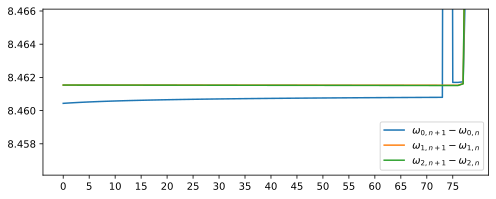

In [7]:
plt.figure(figsize = (8,3))
n_osc_lvls = max_ol-1
dressed_osc_frequencies = [[] for _ in range(3)]
for j in [0,1,2]:
    for i in range(0,max_ol-1):
        dressed_osc_frequencies[j].append(dressed_ener(j,i+1)-dressed_ener(j,i))
        
for j in [0,1,2]:
    plt.plot(list(range(max_ol-1))[:n_osc_lvls], dressed_osc_frequencies[j][:n_osc_lvls],label=rf'$\omega_{{{j},n+1}} - \omega_{{{j},n}}$')

plt.xticks(list(range(n_osc_lvls))[::5])
plt.ylim(Er-0.005, Er+0.005)
# plt.ylim(7.9,7.92)

# plt.xticklabels([str(i) for i in range(n_osc_lvls)])
plt.legend(loc='lower right')

# g0.15 diff 0.0008499562343882161

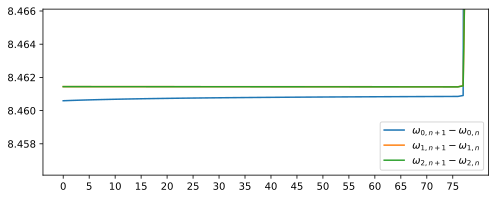

In [9]:
plt.figure(figsize = (8,3))
n_osc_lvls = max_ol-1
dressed_osc_frequencies = [[] for _ in range(3)]
for j in [0,1,2]:
    for i in range(0,max_ol-1):
        dressed_osc_frequencies[j].append(dressed_ener(j,i+1)-dressed_ener(j,i))
        
for j in [0,1,2]:
    plt.plot(list(range(max_ol-1))[:n_osc_lvls], dressed_osc_frequencies[j][:n_osc_lvls],label=rf'$\omega_{{{j},n+1}} - \omega_{{{j},n}}$')

plt.xticks(list(range(n_osc_lvls))[::5])
plt.ylim(Er-0.005, Er+0.005)
# plt.ylim(7.9,7.92)

# plt.xticklabels([str(i) for i in range(n_osc_lvls)])
plt.legend(loc='lower right')

In [9]:

evals, evecs = system.hilbertspace.hamiltonian().eigenstates()
overlap_matrix = scqubits.utils.spectrum_utils.convert_evecs_to_ndarray(evecs)
def print_top_two_dressed_state(product_index):
    overlaps_with_product_state = np.abs(overlap_matrix[:, product_index])
    sorted_indices = np.argsort(overlaps_with_product_state)[::-1]
    sorted_overlaps = overlaps_with_product_state[sorted_indices]
    print(list(sorted_indices)[:2])
    print(list(sorted_overlaps)[:2])

print(f"\t\tqubit 0\t\t\tqubit 1 \t\t qubit 2")

print(f"osc lvl\t\tdressed-overlap^2\tdressed-overlap^2\tdressed-overlap^2")
for i in range(max_ol-1):
    product_index_q0 = 0 * system.osc.truncated_dim + i
    product_index_q1 = 1 * system.osc.truncated_dim + i
    product_index_q2 = 2 * system.osc.truncated_dim + i

    overlaps_with_product_state_q0 = np.abs(overlap_matrix[:, product_index_q0])
    sorted_indices_q0 = np.argsort(overlaps_with_product_state_q0)[::-1]
    sorted_overlaps_q0 = overlaps_with_product_state_q0[sorted_indices_q0]

    overlaps_with_product_state_q1 = np.abs(overlap_matrix[:, product_index_q1])
    sorted_indices_q1 = np.argsort(overlaps_with_product_state_q1)[::-1]
    sorted_overlaps_q1 = overlaps_with_product_state_q1[sorted_indices_q1]
    
    overlaps_with_product_state_q2 = np.abs(overlap_matrix[:, product_index_q2])
    sorted_indices_q2 = np.argsort(overlaps_with_product_state_q2)[::-1]
    sorted_overlaps_q2 = overlaps_with_product_state_q2[sorted_indices_q2]

    print(f"ol-{i}:\t\t{list(sorted_indices_q0)[0]}-{list(sorted_overlaps_q0)[0]**2:.3f} \t\t{list(sorted_indices_q1)[0]}-{list(sorted_overlaps_q1)[0]**2:.3f} \t\t{list(sorted_indices_q2)[0]}-{list(sorted_overlaps_q2)[0]**2:.3f}")

		qubit 0			qubit 1 		 qubit 2
osc lvl		dressed-overlap^2	dressed-overlap^2	dressed-overlap^2
ol-0:		0-1.000 		1-1.000 		2-1.000
ol-1:		7-0.968 		12-1.000 		13-0.999
ol-2:		24-0.939 		32-0.999 		33-0.998
ol-3:		50-0.913 		61-0.999 		62-0.997
ol-4:		80-0.889 		91-0.998 		92-0.996
ol-5:		110-0.867 		121-0.998 		122-0.995
ol-6:		140-0.847 		151-0.998 		152-0.994
ol-7:		170-0.828 		181-0.997 		182-0.993
ol-8:		200-0.811 		211-0.997 		212-0.992
ol-9:		230-0.795 		241-0.996 		242-0.991
ol-10:		260-0.780 		271-0.996 		272-0.990
ol-11:		290-0.765 		301-0.996 		302-0.989
ol-12:		320-0.752 		331-0.995 		332-0.988
ol-13:		350-0.739 		361-0.995 		362-0.987
ol-14:		380-0.727 		391-0.994 		392-0.985
ol-15:		410-0.715 		421-0.994 		422-0.984
ol-16:		440-0.705 		451-0.994 		452-0.983
ol-17:		470-0.694 		481-0.993 		482-0.982
ol-18:		500-0.684 		511-0.993 		512-0.981
ol-19:		530-0.675 		541-0.992 		542-0.980
ol-20:		560-0.665 		571-0.992 		572-0.979
ol-21:		590-0.657 		601-0.992 		602-0.978
ol-22:		620